Implement the Dantzig-Fulkerson-Johnson model for the TSP.
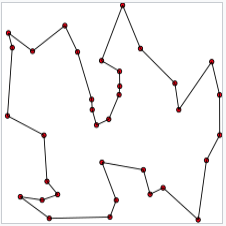

In [1]:
import networkx as nx

n = 20                     # number of cities
G = nx.complete_graph(20)  # graph with a vertex for each city

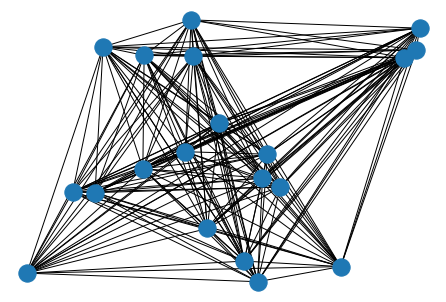

In [2]:
# for convenience, pick the city (x,y)-coordinates at random
import random

my_pos = { i : ( random.random(), random.random() ) for i in G.nodes } # pos[i] = (x_i, y_i)
nx.draw(G, pos=my_pos)

In [3]:
# for convenience, suppose that distances are Euclidean
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [4]:
import gurobipy as gp
from gurobipy import GRB

In [5]:
# First, solve the 2-matching relaxation

m = gp.Model()
x = m.addVars(G.edges,vtype=GRB.BINARY)

m.setObjective( gp.quicksum( G.edges[i,j]['length'] * x[i,j] for i,j in G.edges ), GRB.MINIMIZE )

# Each city should touch the tour twice (enter-and-leave)
m.addConstrs( gp.quicksum( x[e] for e in G.edges if e in G.edges(i) ) == 2 for i in G.nodes )

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 190 columns and 380 nonzeros
Model fingerprint: 0xfc70e386
Variable types: 0 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 9.7963106
Presolve time: 0.00s
Presolved: 20 rows, 190 columns, 380 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 2.845071e+00, 21 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.8450715    2.84507  0.00%   

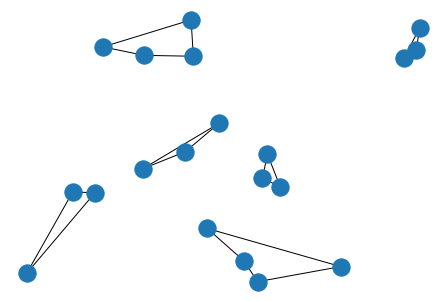

In [6]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

In [7]:
# for each component of the solution, add a subtour elimination inequality 
for component in nx.connected_components(G.edge_subgraph(tour_edges)):
    if len(component) < G.number_of_nodes():
        print("Adding constraint for this component:",component)
        inner_edges = [ (i,j) for (i,j) in G.edges if i in component and j in component ]
        m.addConstr( gp.quicksum( x[e] for e in inner_edges ) <= len(component) - 1 )

Adding constraint for this component: {0, 17, 3}
Adding constraint for this component: {1, 19, 7}
Adding constraint for this component: {2, 12, 13, 14}
Adding constraint for this component: {8, 11, 4, 15}
Adding constraint for this component: {9, 5, 6}
Adding constraint for this component: {16, 10, 18}


In [8]:
# re-optimize
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 26 rows, 190 columns and 404 nonzeros
Model fingerprint: 0xfd146561
Variable types: 0 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 3e+00]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R20 by 1.000000000

Found heuristic solution: objective 9.7963106
Presolve time: 0.00s
Presolved: 26 rows, 190 columns, 404 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 3.708396e+00, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0  

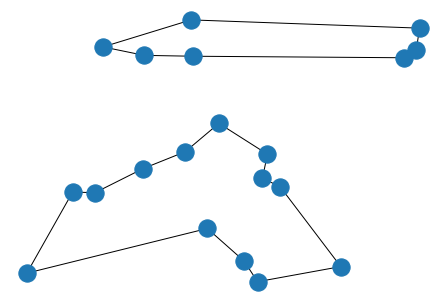

In [9]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

Adding constraint for this component: {0, 1, 2, 3, 7, 10, 12, 13, 14, 16, 17, 18, 19}
Adding constraint for this component: {4, 5, 6, 8, 9, 11, 15}
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 28 rows, 190 columns and 503 nonzeros
Model fingerprint: 0xb4ea3c25
Variable types: 0 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+01]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R26 by 1.000000000

Found heuristic solution: objective 9.7963106
Presolve time: 0.00s
Presolved: 28 rows, 190 columns, 503 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 3.729204e+00, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

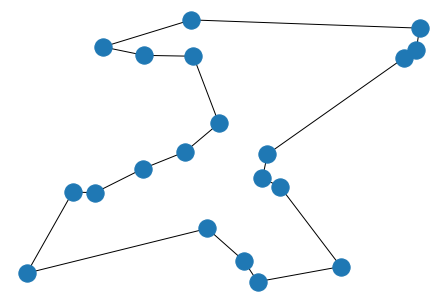

In [10]:
# if necessary, repeat this process:
import matplotlib.pyplot as plt

while not nx.is_connected( G.edge_subgraph(tour_edges) ):
    
    for component in nx.connected_components(G.edge_subgraph(tour_edges)):
        print("Adding constraint for this component:",component)
        inner_edges = [ (i,j) for (i,j) in G.edges if i in component and j in component ]
        m.addConstr( gp.quicksum( x[e] for e in inner_edges ) <= len(component) - 1 )
    
    m.optimize()
    
    # get the solution and draw it
    plt.figure() # call this to create a new figure, instead of drawing over the previous one(s)
    
    tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
    nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)